In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Input
from kafka import KafkaProducer
from kafka import KafkaConsumer, TopicPartition
import json

In [2]:
class Kafka_Send_Receive():
    def kafka_producer(self, df, topic_name):
        producer = KafkaProducer(bootstrap_servers='localhost:9092', value_serializer=lambda v: json.dumps(v).encode('utf-8'))

        # DataFrame do JSON
        df_json = df.to_json(orient='records')
        
        # Sending data to topic
        producer.send(topic_name, df_json)
        producer.flush()  # Ensure that all messages have been sent

        print("Message has been sent to Kafka")

    def kafka_consumer(self, topic_name):
        consumer = KafkaConsumer(
            topic_name,
            bootstrap_servers='localhost:9092',
            auto_offset_reset='earliest',  # To start reading from the oldest messages
            enable_auto_commit=False,  # Disable auto-commit to manually control the offset
            value_deserializer=lambda x: json.loads(x.decode('utf-8'))
        )

        # Get the partition information for a given topic
        partitions = consumer.partitions_for_topic(topic_name)
        if partitions is None:
            print("Error: Unable to find partition for topic")
            return
        
        # Create a TopicPartition for each partition
        topic_partitions = [TopicPartition(topic_name, p) for p in partitions]
        # Get the end and beginning offsets for each partition
        end_offsets = consumer.end_offsets(topic_partitions)
        beginning_offsets = consumer.beginning_offsets(topic_partitions)

        # Check that all partitions are empty
        if all(end_offsets[tp] == beginning_offsets[tp] for tp in topic_partitions):
            print("Topic is empty")
            consumer.close()
            return
        else:
            print("The topic contains messages")

        for message in consumer:
            data_json = message.value
            # JSON to DataFrame
            data_df = pd.read_json(data_json, orient='records')
            print("Data received")
            
            # Create TopicPartition for current message
            current_partition = TopicPartition(topic_name, message.partition)
            
            # Get the current offset for this partition
            current_offset = consumer.position(current_partition)
            
            # Check that the end of available messages for this partition has been reached
            if end_offsets[current_partition] <= current_offset:
                print("The end of available messages for the partition has been reached")
                break
                
        consumer.close()
        return data_df

class PrepareData():
    def __init__(self, start_date, end_date, num_products, num_records, topic_name):
        
        self.df_to_send = self.generate_data(start_date, end_date, num_products, num_records)

        Kafka = Kafka_Send_Receive()
        Kafka.kafka_producer(self.df_to_send, topic_name)
        self.df_received = Kafka.kafka_consumer(topic_name)

        self.X_train_transformed, self.X_val_transformed, self.X_test_transformed, \
        self.y_train, self.y_val, self.y_test, \
        self.X, self.y, self.pipeline = self.prepare_data(self.df_received)

        self.model, self.history = self.build_model(self.X_train_transformed.shape[1])
        self.analyse_results()

    # Data generation
    def generate_data(self, start_date, end_date, num_products, num_records):
        np.random.seed(42)  # For reproducibility

        dates = [start_date + timedelta(days=np.random.randint((end_date - start_date).days)) for _ in range(num_records)]
        product_ids = np.random.randint(1, num_products + 1, size=num_records)
        quantities_sold = np.random.poisson(lam=2, size=num_records)
        prices = np.random.uniform(low=10.0, high=100.0, size=num_records)

        df = pd.DataFrame({
            'date': dates,
            'product_id': product_ids,
            'quantity_sold': quantities_sold,
            'price': prices
        })
        df['is_promotion'] = np.random.choice([True, False], size=num_records, p=[0.2, 0.8])
        df.sort_values('date', inplace=True)
        df['month'] = df['date'].dt.month
        df['day_of_week'] = df['date'].dt.dayofweek
        return df

    # Data preparation
    def prepare_data(self, df):
        
        features = ['month', 'day_of_week', 'product_id', 'price', 'is_promotion']
        target = 'quantity_sold'

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', MinMaxScaler(), ['price']),
                ('cat', OneHotEncoder(), ['product_id', 'is_promotion', 'month', 'day_of_week'])
            ])
        X = df[features]
        y = df[target]
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
        pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
        X_train_transformed = pipeline.fit_transform(X_train)
        X_val_transformed = pipeline.transform(X_val)
        X_test_transformed = pipeline.transform(X_test)
        return X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test, X, y, pipeline

    # Model definition
    def build_model(self, input_shape):
        model = Sequential([
            Input(shape=(input_shape,)),
            Dense(64, activation='relu'),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')

        early_stopping = tf.keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
)
        # Model fit
        history = model.fit(
            self.X_train_transformed, self.y_train,
            validation_data=(self.X_val_transformed, self.y_val),
            batch_size=256,
            epochs=100,
            callbacks=[early_stopping],
            verbose=0
        )
        
        return model, history
    
    def analyse_results(self):        
        # Prediction on the entire data set
        X_transformed = self.pipeline.transform(self.X)
        predictions = self.model.predict(X_transformed).flatten()

        # Adding predictions to a DataFrame
        self.df_received['predicted_quantity_sold'] = predictions

        # Product profitability analysis
        product_profitability = self.df_received.groupby('product_id').apply(
            lambda x: np.sum(x['predicted_quantity_sold'] * x['price'])
        ).reset_index(name='predicted_profit')
        print("Product profitability analysis:")
        print(product_profitability.sort_values('predicted_profit', ascending=False))

        # Analysis of the impact of promotion
        promotion_effect = self.df_received.groupby(['product_id', 'is_promotion']).apply(
            lambda x: np.mean(x['predicted_quantity_sold'])
        ).reset_index(name='average_predicted_quantity')
        print("\nImpact of promotions on average expected number of units sold:")
        print(promotion_effect)

        # Profit forecasting
        self.df_received['predicted_profit'] = self.df_received['predicted_quantity_sold'] * self.df_received['price']
        total_predicted_profit = self.df_received['predicted_profit'].sum()
        print(f"\nTotal expected profit: {total_predicted_profit}")

        # Evaluation of model performance
        # Calculation of predictions on the test set
        y_pred = self.model.predict(self.X_test_transformed).flatten()
        # MAE Calculation
        mae = mean_absolute_error(self.y_test, y_pred)
        print(f"Mean absolute error (MAE): {mae}")
        # MSE Calculation
        mse = mean_squared_error(self.y_test, y_pred)
        print(f"Mean squared error (MSE): {mse}")

        # Visualisation of learning history
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        # Calculating the difference between predictions and actual results
        differences = y_pred - self.y_test
        # Drawing a differential grapha
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(differences)), differences, alpha=0.6)
        # Linia reprezentująca brak różnicy
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.xlabel('Sample number')
        plt.ylabel('Difference (Prediction - Actual value)')
        plt.title('Graph of differences between predictions and actual values')
        plt.show()

Message has been sent to Kafka
The topic contains messages
Data received
Data received
The end of available messages for the partition has been reached
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Product profitability analysis:
   product_id  predicted_profit
0           1      12680.482055
4           5      12343.111496
1           2      10962.415436
2           3      10212.211422
3           4       9150.032990

Impact of promotions on average expected number of units sold:
   product_id  is_promotion  average_predicted_quantity
0           1         False                    2.094133
1           1          True                    2.075339
2           2         False                    2.118737
3           2          True                    2.140971
4           3         False                    2.028916
5           3          True                    1.958900
6           4         False                    1.908553
7           4          True                    1.907521
8           5    

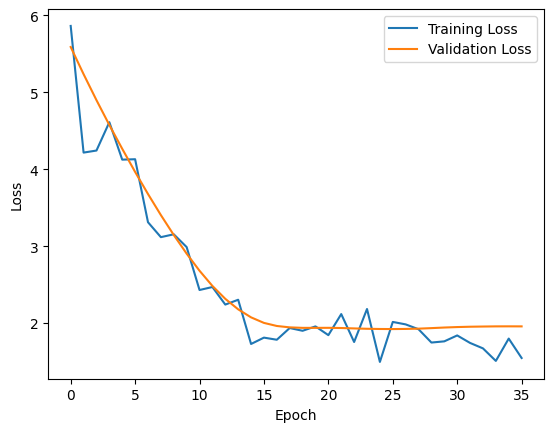

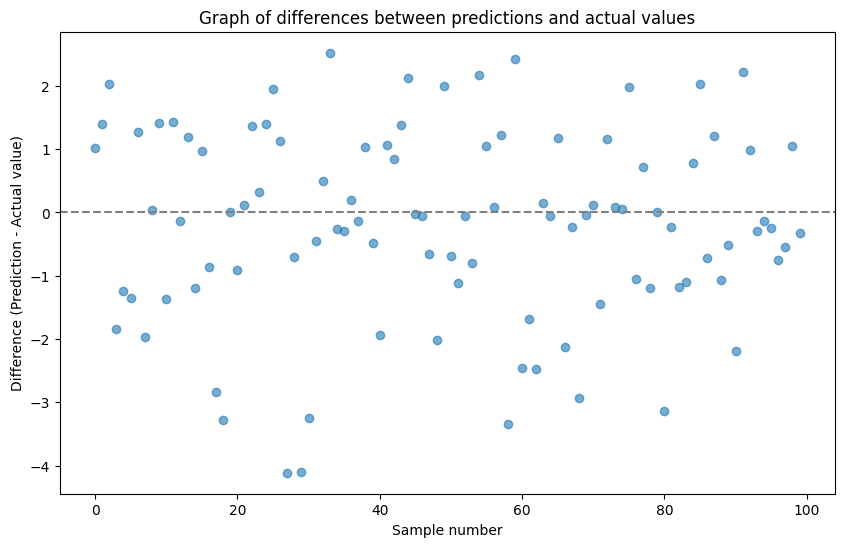

In [3]:
start_date = datetime(2022, 1, 1)
end_date = datetime(2022, 12, 31)
num_products = 5
num_records = 500
features = ['month', 'day_of_week', 'product_id', 'price', 'is_promotion']
target = 'quantity_sold'
topic_name = 'sales_data'

test = PrepareData(start_date, end_date, num_products, num_records, topic_name)